<a href="https://colab.research.google.com/github/caiogasparine/SCS_3253_061-Machine-Learning/blob/main/Toronto_Police_Major_Crime_Indicators_MCI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Source of Data: Major Crime Indicators (MCI) Historical**

This dataset includes all Major Crime Indicators (MCI) occurrences by reported date and related offences from 2014 to June 30, 2022.

https://data.torontopolice.on.ca/pages/major-crime-indicators


# 1 - Big Picture / Frame the problem 
University of Toronto
SCS 3253-061 - Machine Learning // Instructor: Saeid Abolfazli

**Group Members:**
*   Caio Gasparine
*   Fabio Queiroz
*   Olivier Sangam
*   Illidan Yuan

Created on February 18, 2023 / Last update on February 24, 2023

# 2 - Get the data / Develop the pipeline

Data profiling was done to ensure data quality and integrity. Contents of each field were analyzed for any anomalies and Null values. None we found.

In [212]:
### Loading the main used libraries
from datetime import date
import numpy as np
import pandas as pd
import statsmodels.formula.api as sm
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.plotting import scatter_matrix
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
### Change the code here, depending on your dataset location
### data = pd.read_csv('Major_Crime_Indicators.csv', header=0)
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Major_Crime_Indicators.csv', header=0)

In [214]:
data.shape

(301233, 30)

In [215]:
data.columns

Index(['X', 'Y', 'Index_', 'event_unique_id', 'Division', 'occurrencedate',
       'reporteddate', 'location_type', 'premises_type', 'ucr_code', 'ucr_ext',
       'offence', 'reportedyear', 'reportedmonth', 'reportedday',
       'reporteddayofyear', 'reporteddayofweek', 'reportedhour',
       'occurrenceyear', 'occurrencemonth', 'occurrenceday',
       'occurrencedayofyear', 'occurrencedayofweek', 'occurrencehour',
       'mci_category', 'Hood_ID', 'Neighbourhood', 'Longitude', 'Latitude',
       'ObjectId'],
      dtype='object')

# 3 - Explore and visualize the data to gain insights


In [216]:
data.head(5)

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014/01/03 05:00:00+00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [217]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301233 entries, 0 to 301232
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   X                    301233 non-null  float64
 1   Y                    301233 non-null  float64
 2   Index_               301233 non-null  int64  
 3   event_unique_id      301233 non-null  object 
 4   Division             301233 non-null  object 
 5   occurrencedate       301233 non-null  object 
 6   reporteddate         301233 non-null  object 
 7   location_type        301233 non-null  object 
 8   premises_type        301233 non-null  object 
 9   ucr_code             301233 non-null  int64  
 10  ucr_ext              301233 non-null  int64  
 11  offence              301233 non-null  object 
 12  reportedyear         301233 non-null  int64  
 13  reportedmonth        301233 non-null  object 
 14  reportedday          301233 non-null  int64  
 15  reporteddayofyear

In [218]:
data['mci_category'].value_counts()

Assault            161833
Break and Enter     59440
Auto Theft          40794
Robbery             29230
Theft Over           9936
Name: mci_category, dtype: int64

In [219]:
data['location_type'].value_counts()

Apartment (Rooming House, Condo)                                          72061
Single Home, House (Attach Garage, Cottage, Mobile)                       54076
Streets, Roads, Highways (Bicycle Path, Private Road)                     47619
Other Commercial / Corporate Places (For Profit, Warehouse, Corp. Bldg    34774
Parking Lots (Apt., Commercial Or Non-Commercial)                         25322
Bar / Restaurant                                                          12031
Open Areas (Lakes, Parks, Rivers)                                          6278
Schools During Supervised Activity                                         4567
Convenience Stores                                                         3851
Ttc Subway Station                                                         3648
Commercial Dwelling Unit (Hotel, Motel, B & B, Short Term Rental)          3454
Private Property Structure (Pool, Shed, Detached Garage)                   2743
Hospital / Institutions / Medical Facili

In [220]:
data['ucr_code'].value_counts()

1430    110901
2120     59416
2135     40794
1420     34218
1610     29229
2130      7018
1460      5282
1480      3486
1450      3471
1410      2502
2132      2423
1457      1089
1461       559
2133       495
1455       180
1470       106
1462        23
1440        14
2125        13
2121        11
1475         2
1611         1
Name: ucr_code, dtype: int64

In [221]:
data['premises_type'].value_counts()

Outside        80079
Apartment      72061
Commercial     60860
House          54076
Other          17788
Transit         8603
Educational     7766
Name: premises_type, dtype: int64

In [222]:
data['offence'].value_counts()

Assault                           110528
B&E                                50182
Theft Of Motor Vehicle             40794
Assault With Weapon                27191
Robbery - Mugging                   8393
B&E W'Intent                        7311
Assault Bodily Harm                 7027
Theft Over                          5532
Assault Peace Officer               5174
Robbery - Other                     4857
Robbery With Weapon                 4798
Robbery - Business                  4343
Assault - Resist/ Prevent Seiz      3018
Aggravated Assault                  2483
Theft From Motor Vehicle Over       2423
Robbery - Swarming                  2289
Discharge Firearm With Intent       2003
Unlawfully In Dwelling-House        1821
Discharge Firearm - Recklessly      1441
Theft From Mail / Bag / Key         1197
Robbery - Home Invasion             1132
Pointing A Firearm                  1089
Robbery - Purse Snatch              1039
Robbery - Financial Institute        891
Robbery - Vehicl

In [223]:
data['Neighbourhood'].value_counts()

Waterfront Communities-The Island    11302
Church-Yonge Corridor                 9942
Bay Street Corridor                   8530
West Humber-Clairville                8103
Moss Park                             7287
                                     ...  
Yonge-St.Clair                         596
Guildwood                              559
Maple Leaf                             550
Woodbine-Lumsden                       549
Lambton Baby Point                     472
Name: Neighbourhood, Length: 141, dtype: int64

In [224]:
data.describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,3.012330e+05,3.012330e+05,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301233.000000,301133.000000,301133.000000,301133.000000,301233.000000,301233.000000,301233.000000,301233.000000
mean,-8.724562e+06,5.350375e+06,150617.000000,1702.422928,146.565585,2017.876713,15.736659,180.765756,12.808786,2017.822852,15.456476,180.544766,12.601591,-78.374071,43.143874,150617.000000
std,9.966746e+05,6.112283e+05,86958.621157,326.260102,51.988967,2.436940,8.766766,103.717225,6.502562,2.475716,8.914754,104.141362,7.243753,8.953280,4.928613,86958.621157
min,-8.910331e+06,0.000000e+00,1.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2000.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846681e+06,5.412946e+06,75309.000000,1430.000000,100.000000,2016.000000,8.000000,92.000000,8.000000,2016.000000,8.000000,92.000000,7.000000,-79.471086,43.659806,75309.000000
50%,-8.838015e+06,5.419000e+06,150617.000000,1450.000000,100.000000,2018.000000,16.000000,178.000000,13.000000,2018.000000,15.000000,178.000000,14.000000,-79.393238,43.699132,150617.000000
75%,-8.829868e+06,5.426986e+06,225925.000000,2120.000000,200.000000,2020.000000,23.000000,270.000000,18.000000,2020.000000,23.000000,270.000000,19.000000,-79.320056,43.750978,225925.000000
max,0.000000e+00,5.517228e+06,301233.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2022.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301233.000000


In [225]:
### Exploring the data to gain insigths
### Defining our scope with years with complete data 2014 to 2021 // March 7, 2023

### ocurrencedate min = 9/6/1966 and year = NULL AND ocurrencedata max = 30/06/2022
### Clearning the dataset to have the full data for a complete year

data = data[data.occurrenceyear >=2014]
data = data[data.occurrenceyear <=2021]

In [226]:
# Check if any column has missing values ("False" = not missing - "True" = missing)
data.isnull().any()

X                      False
Y                      False
Index_                 False
event_unique_id        False
Division               False
occurrencedate         False
reporteddate           False
location_type          False
premises_type          False
ucr_code               False
ucr_ext                False
offence                False
reportedyear           False
reportedmonth          False
reportedday            False
reporteddayofyear      False
reporteddayofweek      False
reportedhour           False
occurrenceyear         False
occurrencemonth        False
occurrenceday          False
occurrencedayofyear    False
occurrencedayofweek    False
occurrencehour         False
mci_category           False
Hood_ID                False
Neighbourhood          False
Longitude              False
Latitude               False
ObjectId               False
dtype: bool

In [227]:
data[['mci_category','offence','ucr_ext']]

,mci_category,offence,ucr_ext
0,Assault,Assault,100
1,Break and Enter,B&E,200
2,Assault,Assault,100
3,Theft Over,Theft Over,210
4,Robbery,Robbery - Business,210
...,...,...,...
301181,Assault,Assault,100
301183,Assault,Assault,100
301193,Assault,Assault,100
301201,Break and Enter,B&E,200


In [228]:
data["mci_category"].value_counts()

Assault            151290
Break and Enter     56446
Auto Theft          36415
Robbery             27786
Theft Over           9216
Name: mci_category, dtype: int64

In [229]:
data[0:-1].describe()

,X,Y,Index_,ucr_code,ucr_ext,reportedyear,reportedday,reporteddayofyear,reportedhour,occurrenceyear,occurrenceday,occurrencedayofyear,occurrencehour,Longitude,Latitude,ObjectId
count,2.811520e+05,2.811520e+05,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000,281152.000000
mean,-8.725778e+06,5.351167e+06,141581.349932,1700.833784,146.402743,2017.611783,15.747059,186.499072,12.826980,2017.578150,15.492637,186.285347,12.618488,-78.385001,43.150236,141581.726422
std,9.911736e+05,6.078600e+05,81452.205268,325.535828,51.918008,2.261660,8.767522,103.893110,6.519573,2.250528,8.904283,104.130965,7.232712,8.903864,4.901449,81452.770560
min,-8.910331e+06,0.000000e+00,2.000000,1410.000000,100.000000,2014.000000,1.000000,1.000000,0.000000,2014.000000,1.000000,1.000000,0.000000,-80.042866,0.000000,1.000000
25%,-8.846627e+06,5.412955e+06,71136.750000,1430.000000,100.000000,2016.000000,8.000000,98.000000,8.000000,2016.000000,8.000000,98.000000,7.000000,-79.470606,43.659859,71136.750000
50%,-8.837968e+06,5.419022e+06,141569.500000,1450.000000,100.000000,2018.000000,16.000000,189.000000,13.000000,2018.000000,16.000000,189.000000,14.000000,-79.392819,43.699278,141566.500000
75%,-8.829773e+06,5.426993e+06,212066.250000,2120.000000,200.000000,2020.000000,23.000000,276.000000,18.000000,2019.000000,23.000000,276.000000,19.000000,-79.319201,43.751025,212066.250000
max,0.000000e+00,5.517228e+06,301144.000000,2135.000000,230.000000,2022.000000,31.000000,366.000000,23.000000,2021.000000,31.000000,366.000000,23.000000,0.000000,44.333691,301202.000000


In [230]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct = pd.crosstab(data.mci_category, data.reportedyear, margins=True)
data_ct

reportedyear,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
mci_category,,,,,,,,,,
Assault,16397,17936,18844,19255,19771,20997,18228,19290,572,151290
Auto Theft,3595,3278,3349,3626,4819,5354,5768,6570,56,36415
Break and Enter,7152,6938,6443,6933,7610,8548,6985,5746,91,56446
Robbery,3746,3543,3776,4097,3749,3721,2856,2286,12,27786
Theft Over,931,1026,1039,1183,1256,1396,1226,1079,80,9216
All,31821,32721,33451,35094,37205,40016,35063,34971,811,281153


Text(0.5, 1.0, 'MCI Type by Year')

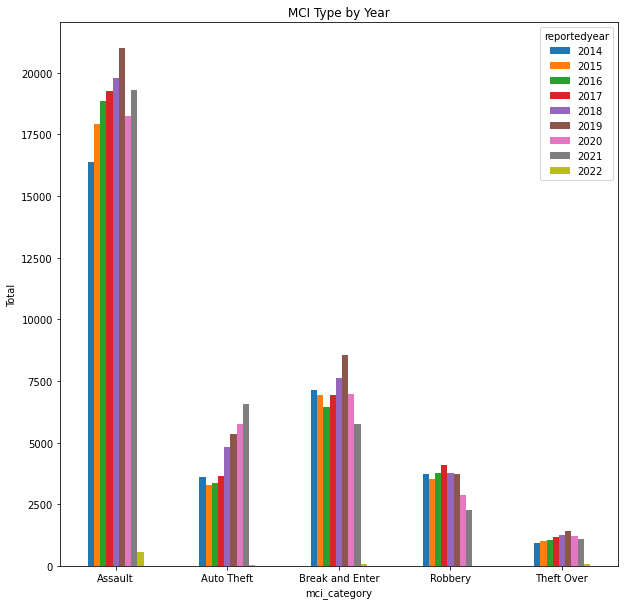

In [231]:
### Exploring the data to gain insigths
### Using pandas crosstab // Feb 24, 2023
data_ct_plot = pd.crosstab(data.mci_category, data.reportedyear)
data_ct_plot.plot(kind='bar', stacked=False, rot = 0, figsize=(10, 10));
plt.ylabel('Total')
plt.title('MCI Type by Year')

In [232]:
### Exploring the data to gain insigths
### Describe from data_crosstable // Feb 27,2023
data_ct[0:-1].describe()

reportedyear,2014,2015,2016,2017,2018,2019,2020,2021,2022,All
count,5.000000,5.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.00000
mean,6364.200000,6544.20000,6690.200000,7018.800000,7441.000000,8003.200000,7012.600000,6994.200000,162.200000,56230.60000
std,6027.453998,6709.20973,7059.890275,7138.566397,7259.776753,7715.993695,6672.650358,7247.092258,231.084833,55786.33751
min,931.000000,1026.00000,1039.000000,1183.000000,1256.000000,1396.000000,1226.000000,1079.000000,12.000000,9216.00000
25%,3595.000000,3278.00000,3349.000000,3626.000000,3749.000000,3721.000000,2856.000000,2286.000000,56.000000,27786.00000
50%,3746.000000,3543.00000,3776.000000,4097.000000,4819.000000,5354.000000,5768.000000,5746.000000,80.000000,36415.00000
75%,7152.000000,6938.00000,6443.000000,6933.000000,7610.000000,8548.000000,6985.000000,6570.000000,91.000000,56446.00000
max,16397.000000,17936.00000,18844.000000,19255.000000,19771.000000,20997.000000,18228.000000,19290.000000,572.000000,151290.00000


In [233]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
### Is a measure of the "tailedness" of the probability distribution of a real-valued random variable. Like skewness, kurtosis describes a particular aspect of a probability distribution. There are different ways to quantify kurtosis for a theoretical distribution, and there are corresponding ways of estimating it using a sample from a population. Different measures of kurtosis may have different interpretations.
### https://en.wikipedia.org/wiki/Kurtosis

data_ct[0:-1].kurtosis()

reportedyear
2014    2.521230
2015    3.081782
2016    3.591290
2017    3.447929
2018    3.164271
2019    2.860853
2020    2.873160
2021    3.136732
2022    4.672804
All     3.273454
dtype: float64

In [234]:
### Exploring the data to gain insigths
### Latitue and Longitude int(values) => 43 / -79 // a couple of ZEROS
data[['Latitude','Longitude']]

,Latitude,Longitude
0,43.766371,-79.504475
1,43.814861,-79.217083
2,43.589085,-79.534957
3,43.703212,-79.346588
4,43.645247,-79.531916
...,...,...
301181,43.717185,-79.372779
301183,43.712045,-79.280963
301193,43.710613,-79.482170
301201,43.706719,-79.245055


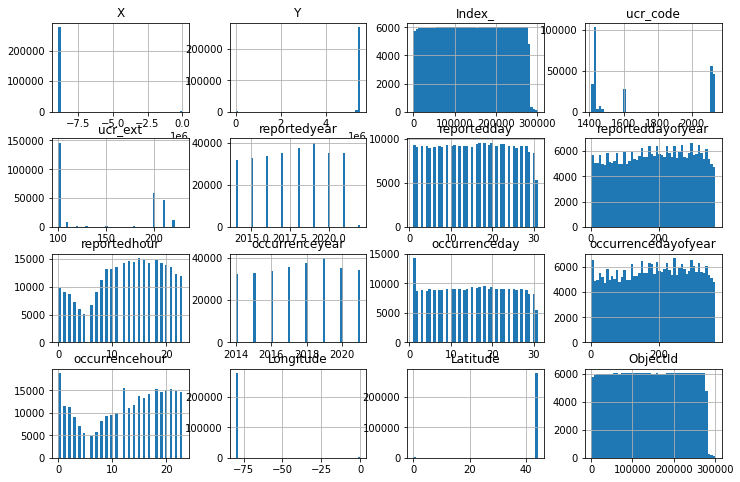

In [235]:
### Exploring the data to gain insigths
### Histogram for each numerical atribute
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(12,8))
plt.show()

reportedyear
2014    16397
2015    17936
2016    18844
2017    19255
2018    19771
2019    20997
2020    18228
2021    19290
2022      572
Name: Assault, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



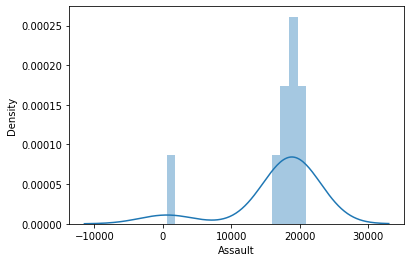

reportedyear
2014    3595
2015    3278
2016    3349
2017    3626
2018    4819
2019    5354
2020    5768
2021    6570
2022      56
Name: Auto Theft, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



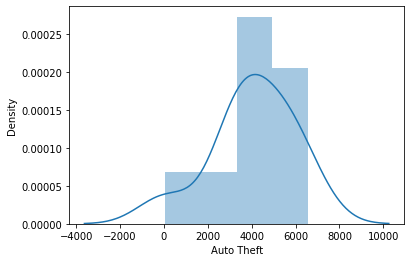

reportedyear
2014    7152
2015    6938
2016    6443
2017    6933
2018    7610
2019    8548
2020    6985
2021    5746
2022      91
Name: Break and Enter, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



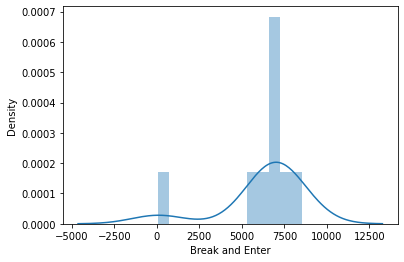

reportedyear
2014    3746
2015    3543
2016    3776
2017    4097
2018    3749
2019    3721
2020    2856
2021    2286
2022      12
Name: Robbery, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



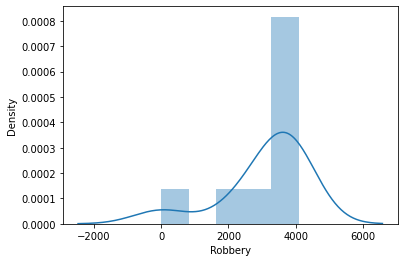

reportedyear
2014     931
2015    1026
2016    1039
2017    1183
2018    1256
2019    1396
2020    1226
2021    1079
2022      80
Name: Theft Over, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



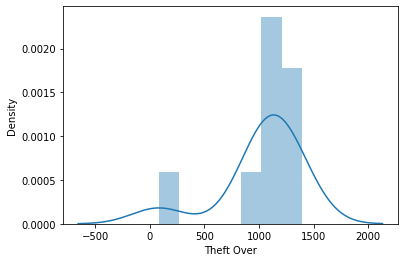

reportedyear
2014    31821
2015    32721
2016    33451
2017    35094
2018    37205
2019    40016
2020    35063
2021    34971
2022      811
Name: All, dtype: int64


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



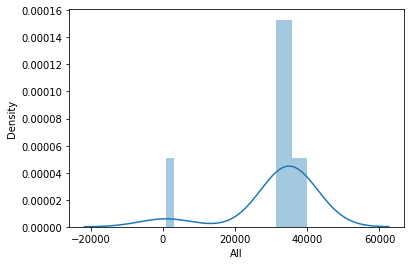

In [236]:
### Exploring the data to gain insigths
### Kurtosis from data_crosstable // Feb 27,2023
for i in range(0, data_ct.shape[0]):
    print (data_ct.iloc[i, 0:-1])
    sns.distplot(data_ct.iloc[i, 0:-1])
    #data_ct.iloc[i, 0:-1].hist(bins=5)
    plt.show()

## 3.1 MCI Category

In [237]:
### Exploring the data to gain insigths // MCI CATEGORY
### Trying to find data correlation / crosstab // Feb 24, 2023
data_ct_t =  pd.crosstab(data.mci_category, data.reportedyear, margins=False).reindex()
data_ct_t = data_ct_t.T
type_corr = data_ct_t.corr()
type_corr

mci_category,Assault,Auto Theft,Break and Enter,Robbery,Theft Over
mci_category,,,,,
Assault,1.000000,0.824192,0.954278,0.883682,0.973190
Auto Theft,0.824192,1.000000,0.733344,0.493837,0.841007
Break and Enter,0.954278,0.733344,1.000000,0.930092,0.959095
Robbery,0.883682,0.493837,0.930092,1.000000,0.848251
Theft Over,0.973190,0.841007,0.959095,0.848251,1.000000


(5.5, -0.5)

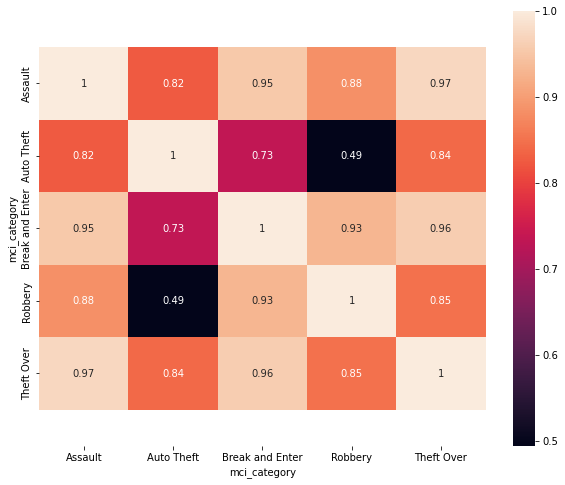

In [238]:
### Exploring the data to gain insigths
### Trying to find data correlation using sns seaborn // Feb 24, 2023
plt.figure(figsize=(10,8))
ax = sns.heatmap(type_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

Correlations:

1.   **Assault** has high correlation with **Theft Over** and **Break and Enter**
2. **Auto Theft** has high correlation with **NONE**
3. **Break and Enter** has correlation with **Roberry** and **Theft Over** 
4. **Robbery** has high correlation with **Break and Enter** and **Assault**
5. **Theft Over** has high correlation with **Assault** and **Break and Enter**

In [239]:
### Exploring the data to gain insigths
### MCI per year analysis // March 7, 2023

mciYear = data_ct.loc['All']
df_ct = data_ct.iloc[:-1,:]
mciYear = mciYear[:-1]
mciYear

reportedyear
2014    31821
2015    32721
2016    33451
2017    35094
2018    37205
2019    40016
2020    35063
2021    34971
2022      811
Name: All, dtype: int64

In [240]:
### Exploring the data to gain insigths
### MCI per year analysis // March 7, 2023

data_annual = pd.concat([pd.Series(mciYear.index, name='Year'), 
                       pd.Series(mciYear.values, name='Type')], axis=1).reset_index()
data_annual = data_annual.drop(columns=['index'])
data_annual

,Year,Type
0,2014,31821
1,2015,32721
2,2016,33451
3,2017,35094
4,2018,37205
5,2019,40016
6,2020,35063
7,2021,34971
8,2022,811


Text(0.5, 1.0, 'Annual Total MCI')

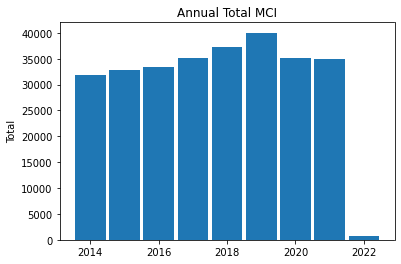

In [241]:
### Exploring the data to gain insigths
### MCI per year analysis / Annual Total MCI Bar graph // March 7, 2023

plt.bar('Year', height='Type', width=0.9, align='center', data=data_annual)
plt.ylabel('Total')
plt.title('Annual Total MCI')

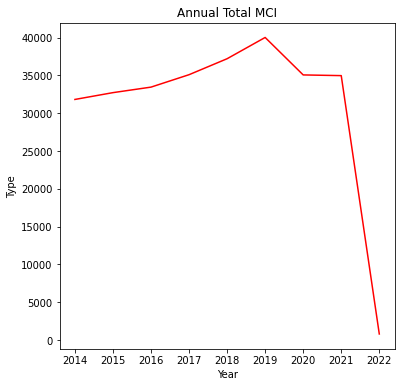

In [242]:
### Exploring the data to gain insigths
### MCI per year analysis / Annual Total MCI Line graph // March 7, 2023

fig, ax = plt.subplots(figsize=(6,6))
sns.lineplot(x='Year', y='Type', data=data_annual, color='r')
ax.set_title('Annual Total MCI')
plt.show()

## 3.3 MCI by neighbourhood

In [243]:
### Exploring the data to gain insigths
### MCI by neighbourhood // March 7, 2023

data_hood_ct = pd.crosstab(data.Neighbourhood, data.occurrenceyear, margins=True)
data_hood_ct.sort_values("All", axis = 0, ascending = False,
                 inplace = True) 
data_hood_ct.head(6)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
All,32467,32920,33608,35501,37440,39967,34973,34277,281153
Waterfront Communities-The Island,1035,1142,1241,1336,1466,1402,1323,1528,10473
Church-Yonge Corridor,876,896,943,1168,1319,1458,1240,1431,9331
Bay Street Corridor,784,960,949,1182,1160,1342,887,798,8062
West Humber-Clairville,887,818,876,936,1145,1014,879,941,7496
Moss Park,654,651,734,718,935,1086,1156,919,6853


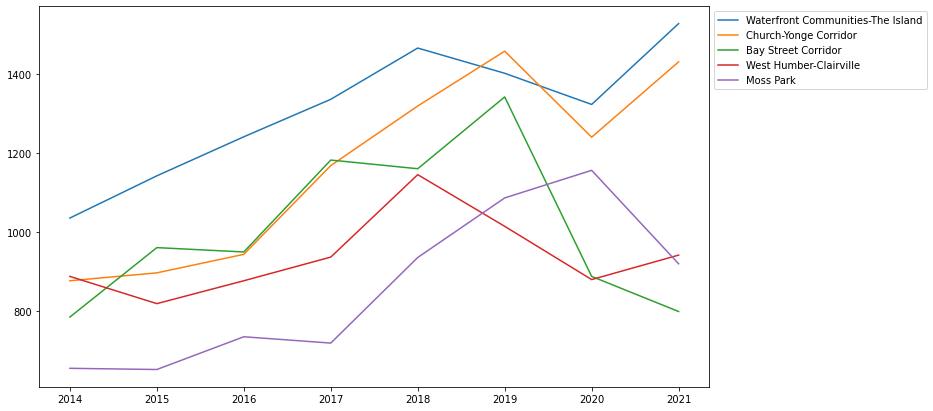

In [244]:
### Exploring the data to gain insigths
### MCI by most dangerous neighbourhood // March 7, 2023

top5dangerous = data_hood_ct.iloc[1:6,:8].T
fig, ax = plt.subplots(1,1,figsize=(12,7))
ax.plot(top5dangerous)
ax.legend(top5dangerous.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

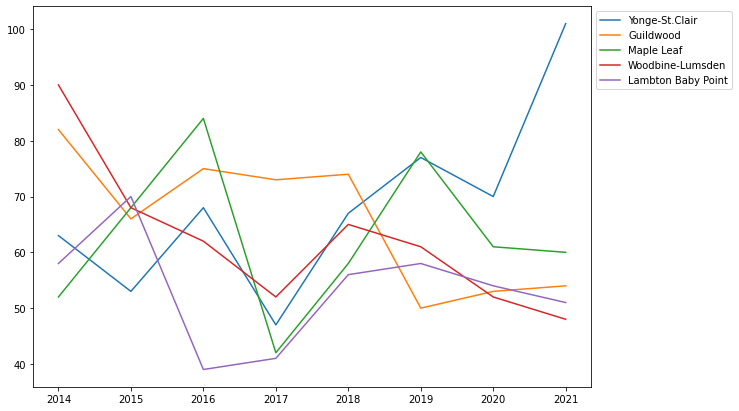

In [261]:
### Exploring the data to gain insigths
### MCI by most dangerous neighbourhood // March 7, 2023

top5safest = data_hood_ct.iloc[-5:,:8].T
fig, ax = plt.subplots(1,1,figsize=(10,7))
ax.plot(top5safest)
ax.legend(top5safest.columns.to_list(), loc="best", bbox_to_anchor = (1,1))

In [262]:
### Exploring the data to gain insigths
### MCI by safest neighbourhood // March 7, 2023

data_hood_ct.tail(5)

occurrenceyear,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0,2021.0,All
Neighbourhood,,,,,,,,,
Yonge-St.Clair,63,53,68,47,67,77,70,101,546
Guildwood,82,66,75,73,74,50,53,54,527
Maple Leaf,52,68,84,42,58,78,61,60,503
Woodbine-Lumsden,90,68,62,52,65,61,52,48,498
Lambton Baby Point,58,70,39,41,56,58,54,51,427


## 3.2 Latitute and Longitude 

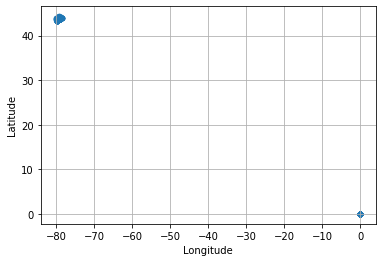

In [246]:
### Exploring the data to gain insigths
### Visualizing Goegraphical Data

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [247]:
### Exploring the data to gain insigths
### Looking for correlations

corr_matrix = data.corr()
corr_matrix ["ucr_code"].sort_values(ascending=False)

ucr_code               1.000000
ucr_ext                0.918850
occurrenceyear         0.031710
Index_                 0.028218
ObjectId               0.028207
Y                      0.026724
Latitude               0.026619
reportedyear           0.026184
occurrencedayofyear    0.014593
occurrenceday          0.010989
reporteddayofyear      0.009899
reportedday            0.000613
Longitude             -0.027076
X                     -0.027076
occurrencehour        -0.041334
reportedhour          -0.072141
Name: ucr_code, dtype: float64

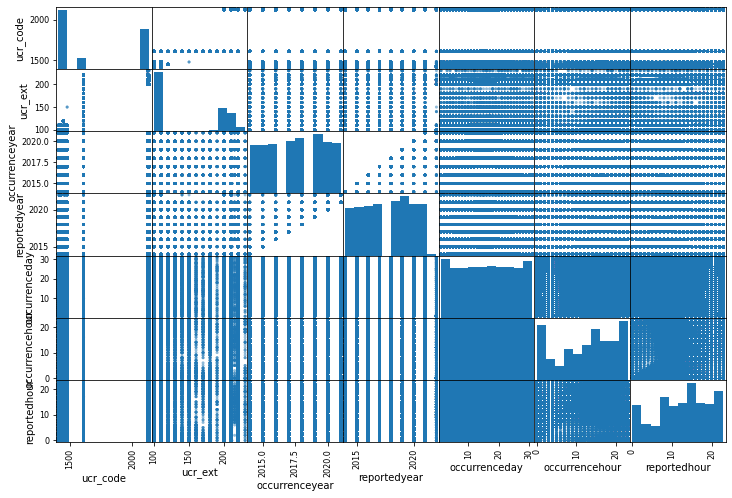

In [248]:
### Exploring the data to gain insigths
### Looking for correlations - using pandas Scatter Matrix
### Scatter Matrix plots every numerical atribute against every other attribite, plus a histogram of each numerical atribute's value on the main diagonal top left to bottom rigth 

from pandas.plotting import scatter_matrix
attributes = ["ucr_code", "ucr_ext", "occurrenceyear", "reportedyear", "occurrenceday", "occurrencehour", "reportedhour"]
scatter_matrix(data[attributes], figsize=(12,8))
plt.show()

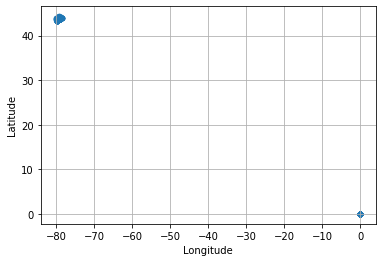

In [249]:
### Exploring the data to gain insigths
### Experiments - Attribute combinations (66)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

In [250]:
### Clean the data (68)
### Get rid of the instance / Get rid of the whole attribute / Set the missing values to some value (zero, median, mean, etc.)
### Panda's dataframe > dropna(), drop(), fillna() + Scikit-Learn SimpleImputer
### Solving the issue with Latitude and Longitude - ZERO VALUES

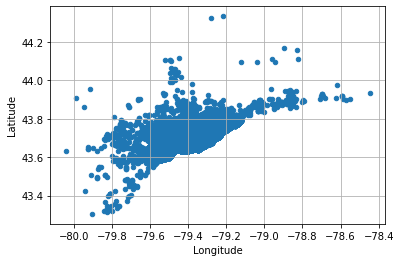

In [251]:
### Replace ZERO values for NaN = "Not a Number"
###data.replace(0, np.nan, inplace=True) ### To replace all the columns

cols = ["Latitude","Longitude"]
data[cols] = data[cols].replace(['0', 0], np.nan)

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True)
plt.show()

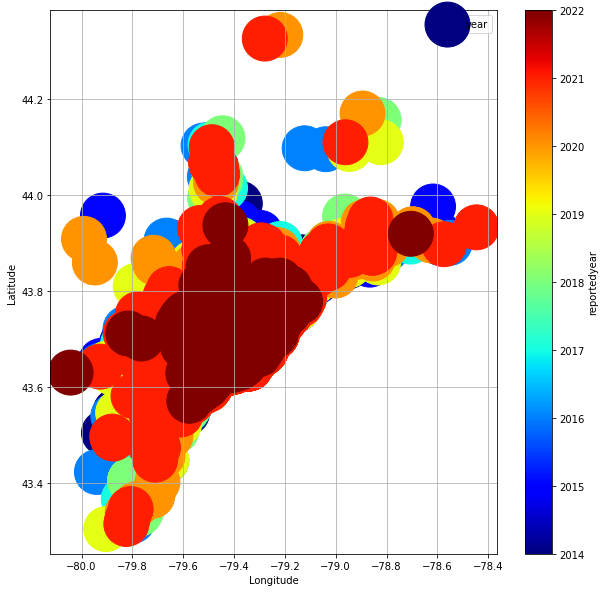

In [252]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=data["reportedyear"], label = "year",
          c="reportedyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

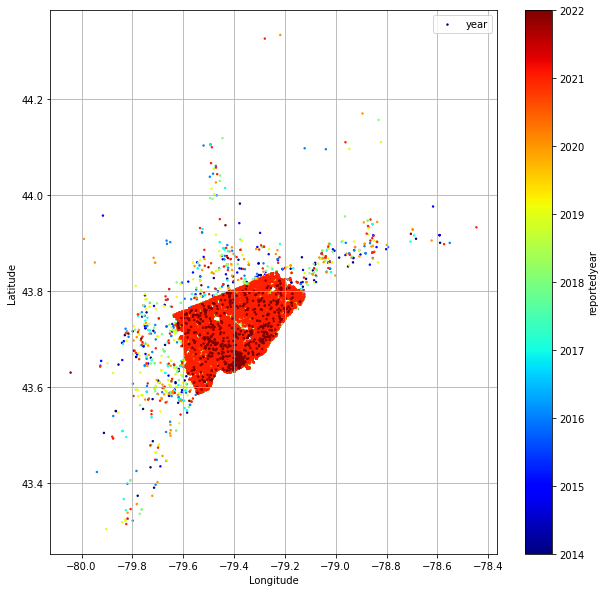

In [253]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###

import matplotlib.pyplot as plt
data.plot(kind="scatter", x="Longitude", y="Latitude", grid=True, 
          s=2, label = "year",
          c="reportedyear", cmap="jet", colorbar=True, 
          legend=True, sharex=False, figsize=(10,10))
plt.show()

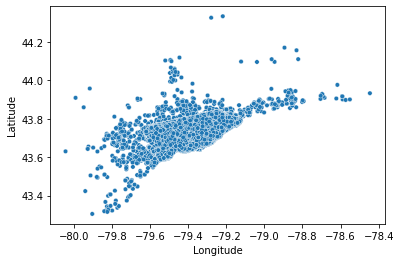

In [254]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import matplotlib.pyplot as plt
import seaborn as sns

graph = data.loc[data.Neighbourhood == 2015]
sns.scatterplot(data=data, x="Longitude", y="Latitude", size=1, legend=False, sizes=(20, 2000))
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:198: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.8/dist-packages/seaborn/matrix.py:203: RuntimeWarning:

All-NaN slice encountered



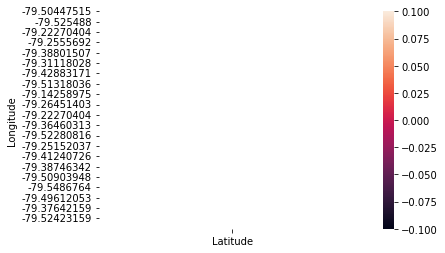

In [255]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###
import seaborn as sns
import pandas as pd
import numpy as np
graph2 = pd.DataFrame(data['Latitude'], data['Longitude'])
p1 = sns.heatmap(graph2)

In [256]:
### Exploring the data to gain insigths
### Ploting Latitude + Longitude to visualize the data
###

import plotly.express as px
import xarray as xr
# Load xarray from dataset included in the xarray tutorial
airtemps = xr.tutorial.open_dataset('air_temperature').air.sel(lon=250.0)
fig = px.imshow(airtemps.T, color_continuous_scale='RdBu_r', origin='lower')
fig.show()

In [257]:
### Adding a new attribute qtd of days since reported first time - using current date
### date.today() / datetime.now()
### time.struct_time((d.year, d.month, d.day, 0, 0, 0, d.weekday(), yday, -1))
### https://docs.python.org/3/library/datetime.html
### class datetime.datetime(year, month, day, hour=0, minute=0, second=0, microsecond=0, tzinfo=None, *, fold=0)

from datetime import date
from datetime import datetime
today_date_iso = (datetime.today())
data['reporteddate'] = pd.to_datetime(data['reporteddate'])
#data['days_since_reported'] = today_date_iso - datetime(data['reporteddate'], tzinfo=None).isoformat() 

#(pd.to_datetime(data['reporteddate']))
#data['reporteddate'] = datetime(data['reporteddate']).isoformat()
#data["days_since_reported"] = (datetime(2023, 2, 23, tzinfo=None).isoformat()) - (datetime(data['reporteddate'], tzinfo=None).isoformat())

#today = today.replace(tzinfo=None)


In [258]:
today_date_iso
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 281153 entries, 0 to 301205
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype              
---  ------               --------------   -----              
 0   X                    281153 non-null  float64            
 1   Y                    281153 non-null  float64            
 2   Index_               281153 non-null  int64              
 3   event_unique_id      281153 non-null  object             
 4   Division             281153 non-null  object             
 5   occurrencedate       281153 non-null  object             
 6   reporteddate         281153 non-null  datetime64[ns, UTC]
 7   location_type        281153 non-null  object             
 8   premises_type        281153 non-null  object             
 9   ucr_code             281153 non-null  int64              
 10  ucr_ext              281153 non-null  int64              
 11  offence              281153 non-null  object             
 12  re

,X,Y,Index_,event_unique_id,Division,occurrencedate,reporteddate,location_type,premises_type,ucr_code,...,occurrenceday,occurrencedayofyear,occurrencedayofweek,occurrencehour,mci_category,Hood_ID,Neighbourhood,Longitude,Latitude,ObjectId
0,-8.850398e+06,5.429359e+06,201,GO-20141273318,D31,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Apartment (Rooming House, Condo)",Apartment,1430,...,3.0,3.0,Friday,11,Assault,27,York University Heights,-79.504475,43.766371,1
1,-8.818405e+06,5.436836e+06,202,GO-20141274349,D42,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Single Home, House (Attach Garage, Cottage, Mo...",House,2120,...,3.0,3.0,Friday,14,Break and Enter,132,Malvern,-79.217083,43.814861,2
2,-8.853791e+06,5.402071e+06,203,GO-20141274052,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,"Open Areas (Lakes, Parks, Rivers)",Outside,1430,...,3.0,3.0,Friday,13,Assault,19,Long Branch,-79.534957,43.589085,3
3,-8.832822e+06,5.419628e+06,204,GO-20141276966,D53,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Other Commercial / Corporate Places (For Profi...,Commercial,2130,...,3.0,3.0,Friday,12,Theft Over,55,Thorncliffe Park,-79.346588,43.703212,4
4,-8.853452e+06,5.410706e+06,205,GO-20141274457,D22,2014/01/03 05:00:00+00,2014-01-03 05:00:00+00:00,Convenience Stores,Commercial,1610,...,3.0,3.0,Friday,14,Robbery,14,Islington-City Centre West,-79.531916,43.645247,5


In [259]:
dia = datetime.now(tz=None).isoformat()
dia

'2023-03-07T16:45:18.801458'

In [260]:
print (datetime(2023, 2, 23, tzinfo=None).isoformat())
#current date format -> 2014/01/03 05:00:00+00

2023-02-23T00:00:00


# 4 - Prepare the data for ML algorithm


# 5 - Select a Model and Train it

6 - Fine-tuning the model 

# 6 - Fine-tunig the model

# Results and Model Performance 